# Hands-on 2: Classification

## Preparation

*Before we start the pratical section, we will take the time to import some libraries, define some colours for our plots and create some functions to generate artificial data. Dont worry too much about this first steps.*

In [1]:
# Basic inputs
import numpy as np
from numpy import mean
from numpy import std

from scipy import linalg
from scipy import stats

# Drawing modules
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from matplotlib.patches import Ellipse

# Utilities
from operator import itemgetter

# Import some tools from Scikit-Learn
# Metrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# Inspection tools
from sklearn.inspection import DecisionBoundaryDisplay

# Create color maps
cmap_light_b = ListedColormap(["#FFAAAA", "#AAFFAA", "#AAAAFF"])
cmap_light = ListedColormap(["#FFAAAA", "#AAAAFF", "#AAFFAA"])
#cmap_light = ListedColormap(['red', 'blue', 'green'])
cmap_bold = ListedColormap(["#FF0000", "#0000FF", "#00FF00"])

my_cmap= ListedColormap(['#ff3d3d', '#3d3dff', '#2dc22d', '#fcea19'])

colors = ["red","blue"]
cmap1 = LinearSegmentedColormap.from_list("mycmap", colors)

# Create color dictionary for classes
color_class = { 0 : 'red'
               ,1 : 'blue'
               ,2 : 'green'
               ,3 : 'yellow'
            }

In [2]:
# Data creation : Gaussian samples with fixed covariances
# a bit misterious but not too much

def dataset_fixed_cov(n=300,dim=2):
    """Generate 2 Gaussians samples with the same covariance matrix"""
    #n, dim = 300, 2
    np.random.seed(0)
    # centers
    C = np.array([[0.0, -0.23], [0.83, 0.23]])
    X = np.r_[
        np.dot(np.random.randn(n, dim), C),
        np.dot(np.random.randn(n, dim), C) + np.array([1, 1]),
    ]
    y = np.hstack((np.zeros(n), np.ones(n)))
    return X, y


def dataset_cov():
    """Generate 2 Gaussians samples with different covariance matrices"""
    n, dim = 300, 2
    np.random.seed(0)
    C = np.array([[0.0, -1.0], [2.5, 0.7]]) * 2.0
    X = np.r_[
        np.dot(np.random.randn(n, dim), C),
        np.dot(np.random.randn(n, dim), C.T) + np.array([1, 4]),
    ]
    y = np.hstack((np.zeros(n), np.ones(n)))
    return X, y

def Test_model_accuracy(y_pred, y_test):

    dif =  (y_pred - y_test)==0
    count=np.unique(dif, return_counts=True)

    accuracy = count[1][1]/len(y_test)
    print ('Accuracy (direct calculation): ', accuracy)

    Conf_Mat = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = Conf_Mat.ravel()

    print('True positive: ', tp)
    print('True negative: ', tn)
    print('False positive: ', fp)
    print('False negative: ', fn)

    print ('Accuracy (Conf. Matrix): ', (tp+tn)/(tp+tn+fp+fn))
    prec = tp/(tp+fp)
    print ('Precision (Conf. Matrix): ', prec)
    rec = tp/(tp+fn)
    print ('Recall (Conf. Matrix): ', rec)
    f1s = 2*(rec*prec/(rec+prec))
    print ('F1-score (Conf. Matrix): ', f1s)
    print ('F1-score (skl metrics): ', f1_score(y_test, y_pred))


### A first contact with the problem

Here, we start by using a function (`dataset_fixed_cov`) to colect our artificial data. Try to print and check the shape of `X` and `y`.

In [3]:
# Create or load the data
N_sample = 300
N_dim =2

X,y = dataset_fixed_cov(N_sample,N_dim)

Even more helpful in the case of 2D data, lets also plot this data and try to understand what it is. Here, the plot at the left is just a scatter plot of the data points. In the right, we recolour the same plot with the classes labelled in `y`.

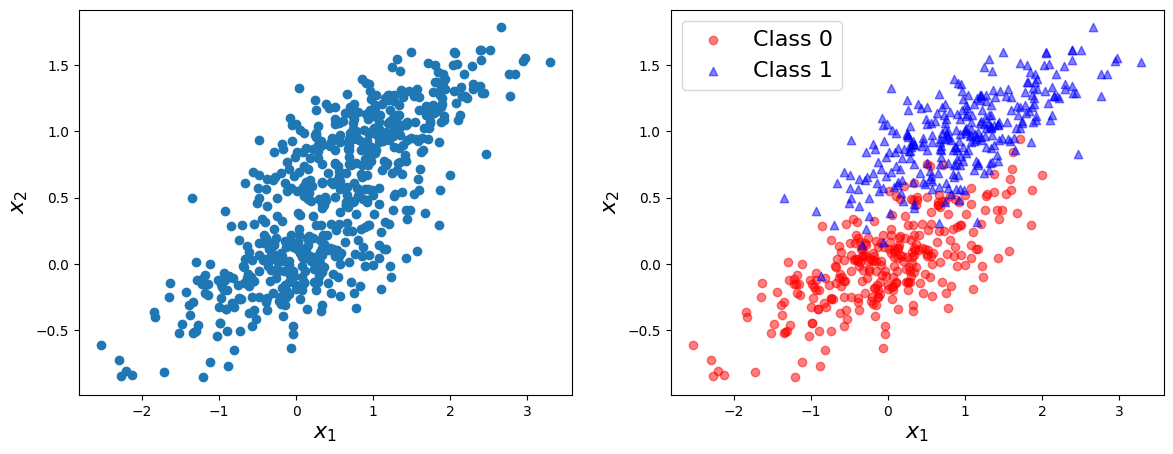

In [4]:
Figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
ax1.scatter(X[:,0],X[:,1])
ax1.set_xlabel(r'$x_1$',fontsize = 16)
ax1.set_ylabel(r'$x_2$',fontsize = 16)

X0_s, X1_s = X[y == 0], X[y == 1]
ax2.scatter(X0_s[:,0],X0_s[:,1], marker = 'o', color = color_class[0], alpha=0.5, label='Class 0')
ax2.scatter(X1_s[:,0],X1_s[:,1], marker = '^', color = color_class[1], alpha=0.5, label='Class 1')
ax2.set_xlabel(r'$x_1$',fontsize = 16)
ax2.set_ylabel(r'$x_2$',fontsize = 16)
ax2.legend(loc='best',fontsize = 16)

Figure.show()

### Train-test split

What we will do in the next sections is to train models capable to classify points as pertencing to one of those two classes. To do so, we will separate a test set from the data that will be used in the training.

In [5]:
# Here we use now the train test split of Scikit-learn
from sklearn.model_selection import train_test_split

# Define a random state for reproducibility during the different use and methods
random_state = 1234

# split the dataset into a train set and a test set : usually 80% of the data in the training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=random_state)

### Visualize the train and test with the classes

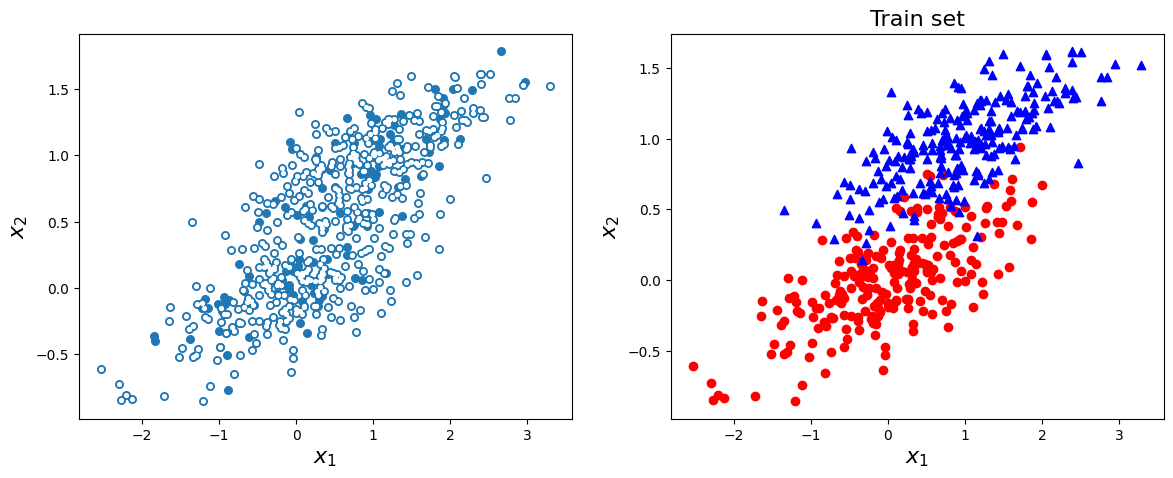

In [6]:
Figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
ax1.scatter(X[:,0],X[:,1], marker = 'o', s = 30)
ax1.scatter(X_train[:,0],X_train[:,1], marker = '.', s = 30, color='white')
ax1.set_xlabel(r'$x_1$',fontsize = 16)
ax1.set_ylabel(r'$x_2$',fontsize = 16)

# separate instances with classes 0 and 1 for the drawing
X0_tr, X1_tr = X_train[y_train == 0], X_train[y_train == 1]

ax2.scatter(X0_tr[:,0],X0_tr[:,1], marker = 'o', color = color_class[0])
ax2.scatter(X1_tr[:,0],X1_tr[:,1], marker = '^', color = color_class[1])
ax2.set_title('Train set',fontsize = 16)
ax2.set_xlabel(r'$x_1$',fontsize = 16)
ax2.set_ylabel(r'$x_2$',fontsize = 16)

Figure.show()

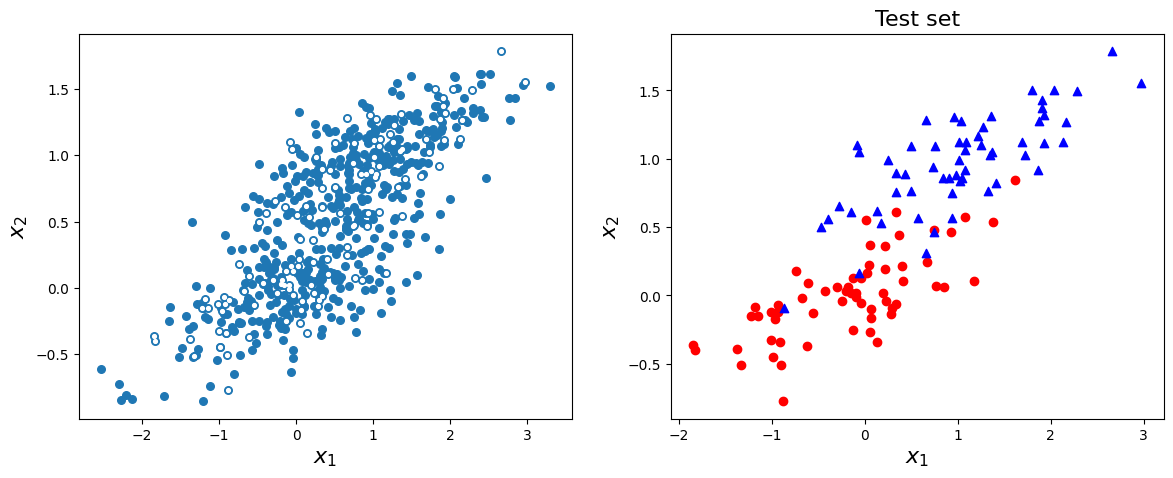

In [7]:
Figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
ax1.scatter(X[:,0],X[:,1], marker = 'o', s = 30)
ax1.scatter(X_test[:,0],X_test[:,1], marker = '.', s = 30, color='white')
ax1.set_xlabel(r'$x_1$',fontsize = 16)
ax1.set_ylabel(r'$x_2$',fontsize = 16)

# separate instances with classes 0 and 1 for the drawing
X0_t, X1_t = X_test[y_test == 0], X_test[y_test == 1]


ax2.scatter(X0_t[:,0],X0_t[:,1], marker = 'o', color='red')
ax2.scatter(X1_t[:,0],X1_t[:,1], marker = '^', color='blue')
ax2.set_title('Test set',fontsize = 16)
ax2.set_xlabel(r'$x_1$',fontsize = 16)
ax2.set_ylabel(r'$x_2$',fontsize = 16)

Figure.show()

### Linear discriminant analysis (LDA)

In a first step LDA is used to analyze the dataset in each of the two components $x_1$ and $x_2$ to see how the classes separate on each of them.

In particular, we will  
* see how they spread on $x_1$ and $x_2$,
* calculate their cendroids
* Calculate the bivariate correlation and represent them


### Train the model

In [8]:
# Here is the classifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [9]:
# create the model
lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
model_lda = lda.fit(X_train, y_train)

y_pred = model_lda.predict(X_test)

print('Centroids:\n',model_lda.means_)
print('Covariance matrix:\n',model_lda.covariance_)

Centroids:
 [[0.01911679 0.01620367]
 [0.95632415 0.97755106]]
Covariance matrix:
 [[0.67010262 0.17952832]
 [0.17952832 0.09820156]]


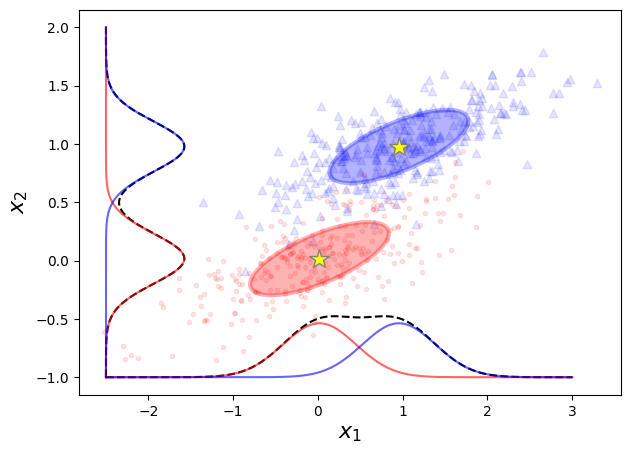

In [10]:
# Plot the centroids and covariance ellipses

Figure, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(7,5))

# plot the dataset separated in two classes
#
X0_s, X1_s = X[y == 0], X[y == 1]
ax2.scatter(X0_s[:,0],X0_s[:,1], marker = '.', color = 'red', alpha=0.1)
ax2.scatter(X1_s[:,0],X1_s[:,1], marker = '^', color = 'blue', alpha=0.1)
ax2.set_xlabel(r'$x_1$',fontsize = 16)
ax2.set_ylabel(r'$x_2$',fontsize = 16)

# Plot the centroids
#
ax2.plot(
   model_lda.means_[0][0],
   model_lda.means_[0][1],
   "*",
   color="yellow",
   markersize=15,
   markeredgecolor="grey",
)
ax2.plot(
   model_lda.means_[1][0],
   model_lda.means_[1][1],
   "*",
   color="yellow",
   markersize=15,
   markeredgecolor="grey",
)

# The eigenvalues of the covatiance matrix are calculated
# Determine the pricipal vectors of the bivariates distributions
# This is similar to the principal component analysis
#
v, w = linalg.eigh(model_lda.covariance_)

# For class 0
u = w[0] / linalg.norm(w[0])
angle = np.arctan(u[1] / u[0])
angle = 180 * angle / np.pi  # convert to degrees

# For class 1
u2 = w[1] / linalg.norm(w[1])
angle = np.arctan(u2[1] / u2[0])
angle = 180 * angle / np.pi  # convert to degrees

# fill the aera corresponding to a Gaussian inside 2 times the standard deviation
# This is a filled Ellipse
ell0 = Ellipse(
    lda.means_[0,:],
    2 * v[0] ** 0.5,
    2 * v[1] ** 0.5,
    angle = 90 + angle,
    facecolor='red',
    edgecolor="red",
    linewidth=3,
)

ell1 = Ellipse(
    lda.means_[1,:],
    2 * v[0] ** 0.5,
    2 * v[1] ** 0.5,
    angle = 90 + angle,
    facecolor='blue',
    edgecolor="blue",
    linewidth=3,
)

ell0.set_clip_box(ax2.bbox)
ell0.set_alpha(0.3)
ell1.set_clip_box(ax2.bbox)
ell1.set_alpha(0.3)
ax2.add_artist(ell0)
ax2.add_artist(ell1)

#Plot the distribution on each axis
fact = 0.5
offs = -1
x =  np.linspace(-2.5,3,200)
y1 = fact*stats.norm.pdf(x, loc= model_lda.means_[0][0], scale=2*v[0]**0.5)
y2 = fact*stats.norm.pdf(x, loc= model_lda.means_[1][0], scale=2*v[0]**0.5)

fact2 = 0.5
offs2 = -2.5
x2 =  np.linspace(-1,2,200)
y12 = fact2*stats.norm.pdf(x2, loc= model_lda.means_[0][1], scale=v[0]**0.5)
y22 = fact*stats.norm.pdf(x2, loc= model_lda.means_[1][1], scale=v[0]**0.5)
ax2.plot(x, offs+y1+y2, color='black', linestyle = 'dashed')
ax2.plot(x, offs+y1, color='red', alpha = 0.6)
ax2.plot(x, offs+y2, color='blue', alpha = 0.6)

ax2.plot(offs2+y12+y22, x2, color='black', linestyle = 'dashed')
ax2.plot(offs2+y12, x2, color='red', alpha = 0.6)
ax2.plot(offs2+y22, x2, color='blue', alpha = 0.6)
#ax2.plot(x,offs+y1+y2,color='black',linestyle='-',alpha = 0.5)


#ax2.set_xticks(())
#ax2.set_yticks(())

Figure.show()

#### Analysis
* From the gaussian distributions used to represent the data, $x_1$ and $x_2$ are both representative of the $2$ classes
* The classes are more separated on axis $x_2$, we can imagine that the line of separation will be on this axix

## Binary classification

### Logistic regression

In [11]:
from sklearn.linear_model import LogisticRegression

In [12]:
# Create the model for binary classification
# 'liblinear' and 'ovr' are chosen here for binary logistic regression.
# Please note: for multinomial logistic regression, you can use 'lbfgs' and 'multinomial'.

logreg = LogisticRegression(solver='liblinear', multi_class='ovr')

In [13]:
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
proba_log = logreg.predict_proba(X_test)

Test_model_accuracy(y_pred, y_test)

Accuracy (direct calculation):  0.9333333333333333
True positive:  55
True negative:  57
False positive:  4
False negative:  4
Accuracy (Conf. Matrix):  0.9333333333333333
Precision (Conf. Matrix):  0.9322033898305084
Recall (Conf. Matrix):  0.9322033898305084
F1-score (Conf. Matrix):  0.9322033898305084
F1-score (skl metrics):  0.9322033898305084


#### How does the algorithm affects the observation to a specific class ?

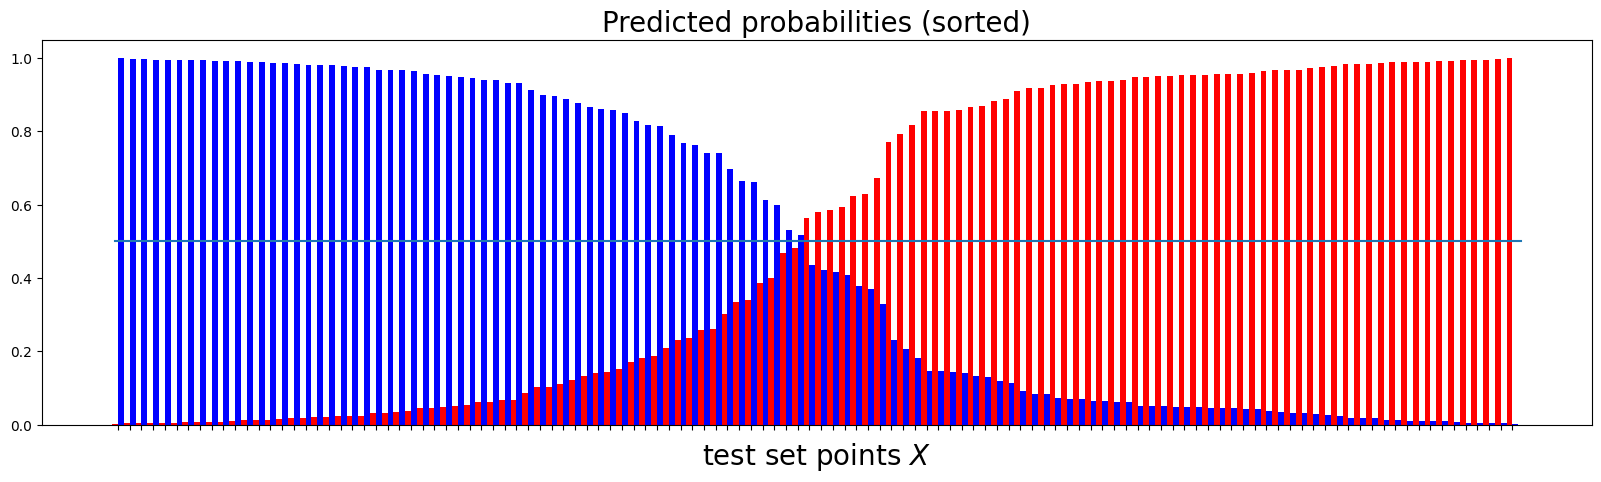

In [14]:
#figbar, (ax1,ax2) = plt.subplots(nrows=2, ncols = 1,figsize = (20,12))
barwidth = 0.5
figbar, ax1 = plt.subplots(nrows=1, ncols = 1,figsize = (20,5))
#ax1.tick_params(labelsize=18)
#ax2.tick_params(labelsize=18)
r1 = range(len(proba_log[:,0]))
r2 = [x + barwidth for x in r1]

prob_sort=[x.tolist() for x in sorted(proba_log, key=itemgetter(0))]
probA=[x[0] for x in prob_sort]
probB=[x[1] for x in prob_sort]

ax1.bar(r1, probA, width = barwidth, color=[color_class[0] for i in r1])
ax1.bar(r2, probB, width = barwidth, color=[color_class[1] for i in r1])
ax1.plot([0,len(proba_log[:,0])],[0.5,0.5])
ax1.set_title(r'Predicted probabilities (sorted)',fontsize = 20)
plt.xticks([r + barwidth / 2 for r in range(len(proba_log[:,0]))],[i for i in range(len(proba_log[:,0]),100)])
#ax2.set_title(r'Predicted probabilities of class $1$',fontsize = 20)
ax1.set_xlabel(r'test set points $X$',fontsize = 20)
#ax2.set_xlabel(r'test set points $X$',fontsize = 20)

#plt.tight_layout()
plt.show()

#### Now draw the decision line

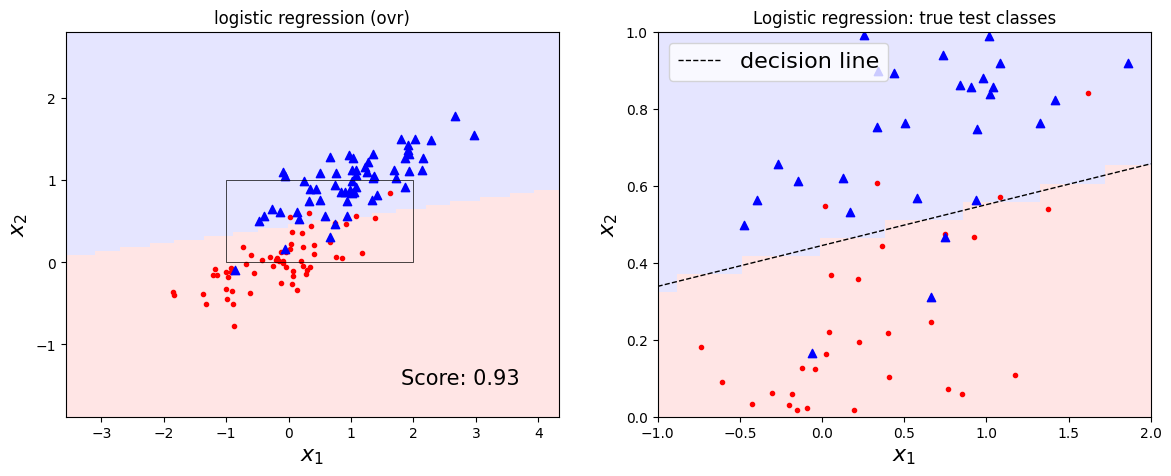

In [15]:
# Display
h = 0.01  # step size in the mesh
name = 'logistic regression'
Figure, (ax,ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (14,5))
ax.set_xlabel(r'$x_1$',fontsize = 16)
ax.set_ylabel(r'$x_2$',fontsize = 16)
ax2.set_xlabel(r'$x_1$',fontsize = 16)
ax2.set_ylabel(r'$x_2$',fontsize = 16)
ax2.set_xlim(xmin=-1,xmax=2)
ax2.set_ylim(ymin=0,ymax=1)

# Retrieve the model parameters for the decision line.
b = logreg.intercept_[0]
w1, w2 = logreg.coef_.T
# Calculate the intercept and gradient of the decision boundary.
c = -b/w2
m = -w1/w2

# Plot the data and the classification with the decision boundary.
xmin, xmax = -1, 2
ymin, ymax = 0, 1
xd = np.array([xmin, xmax])
yd = m*xd + c
ax2.plot(xd, yd, color = 'black', linewidth = 1, linestyle = '--', label = 'decision line')


DecisionBoundaryDisplay.from_estimator(
        logreg,
        X,
        cmap=cmap_light_b,
        alpha=0.3,
        ax=ax,
        response_method="predict",
        plot_method="pcolormesh",
        shading="auto"
    )

# Plot also  testing points
ax.scatter(X0_t[:,0],X0_t[:,1], marker = '.', color=color_class[0])
ax.scatter(X1_t[:,0],X1_t[:,1], marker = '^', color=color_class[1])

ax.set_title("{} ({})".format(name, 'ovr'))

ax.text(
        0.8,
        0.1,
        "Score: {:.2f}".format(f1_score(y_test, y_pred)),
        size=15,
        ha="center",
        va="center",
        transform=ax.transAxes,
)

rect=Rectangle((-1, 0), 3, 1,
    facecolor = None,
    fill = None,
    edgecolor = "black",
    linewidth=0.5)
ax.add_patch(rect)

DecisionBoundaryDisplay.from_estimator(
        logreg,
        X,
        cmap=cmap_light_b,
        alpha=0.3,
        ax=ax2,
        response_method="predict",
        plot_method="pcolormesh",
        shading="auto"
    )

# Plot also  testing points
ax2.scatter(X0_t[:,0],X0_t[:,1], marker = '.', color='red')
ax2.scatter(X1_t[:,0],X1_t[:,1], marker = '^', color='blue')
ax2.set_title("Logistic regression: true test classes")
ax2.legend(fontsize = 16)
Figure.show()

In [16]:
# Import some tools from Scikit-Learn

# Metrix

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# Inspection tools
from sklearn.inspection import DecisionBoundaryDisplay

### Suport Vector Machines (SVM)

In [17]:
from sklearn.svm import SVC

In [18]:
# Create and train the SVM model
svmlin = SVC(kernel='linear') # 'linear' kernel is used here.
svmlin.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = svmlin.predict(X_test)

Test_model_accuracy (y_pred, y_test)

Accuracy (direct calculation):  0.9416666666666667
True positive:  55
True negative:  58
False positive:  3
False negative:  4
Accuracy (Conf. Matrix):  0.9416666666666667
Precision (Conf. Matrix):  0.9482758620689655
Recall (Conf. Matrix):  0.9322033898305084
F1-score (Conf. Matrix):  0.94017094017094
F1-score (skl metrics):  0.94017094017094


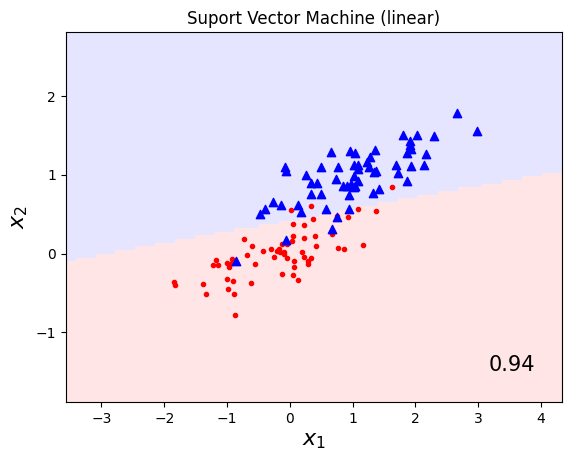

In [19]:
# Display
h = 0.01  # step size in the mesh
name = 'Suport Vector Machine'
Figure, ax = plt.subplots()
ax.set_xlabel(r'$x_1$',fontsize = 16)
ax.set_ylabel(r'$x_2$',fontsize = 16)

DecisionBoundaryDisplay.from_estimator(
        svmlin,
        X,
        cmap=cmap_light_b,
        alpha=0.3,
        ax=ax,
        response_method="predict",
        plot_method="pcolormesh",
        shading="auto",
    )

# Plot also  testing points
#plt.scatter(X_test[:, 0], X_[:, 1], c=y, cmap=cmap_bold, edgecolor="k", s=20)
ax.scatter(X0_t[:,0],X0_t[:,1], marker = '.', color='red')
ax.scatter(X1_t[:,0],X1_t[:,1], marker = '^', color='blue')

plt.title("{} ({})".format(name, "linear"))
plt.text(
        0.9,
        0.1,
        "{:.2f}".format(f1_score(y_test, y_pred)),
        size=15,
        ha="center",
        va="center",
        transform=plt.gca().transAxes,
)

Figure.show()

#### Checking the different SVM models:

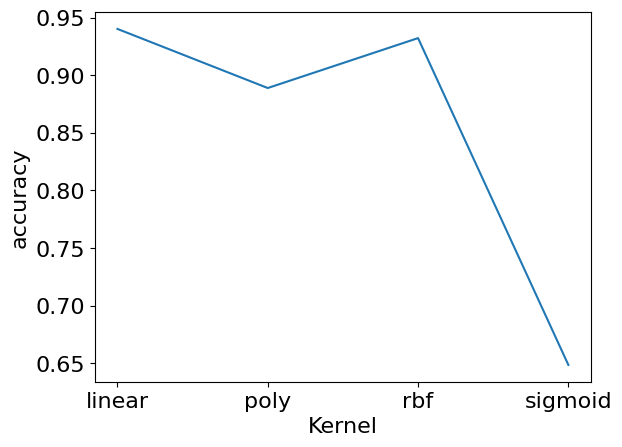

In [20]:
# The list of possible kernels
#
kernels = ['linear', 'poly','rbf','sigmoid']

svms=[]
predict_svms=[]
accuracy_svms = []

# Create and train for each SVM model
#
for k in kernels:
    svm = SVC(kernel=k) # 'lbf' kernel is used here.
    svm.fit(X_train, y_train)
    svms.append(svm)
    # Make predictions and evaluate the model
    y_pred = svm.predict(X_test)
    predict_svms.append(y_pred)
    accuracy_svms.append(f1_score(y_pred, y_test))

plt.plot(kernels,accuracy_svms)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlabel(r'Kernel',fontsize = 16)
plt.ylabel(r'accuracy',fontsize = 16)
plt.show()

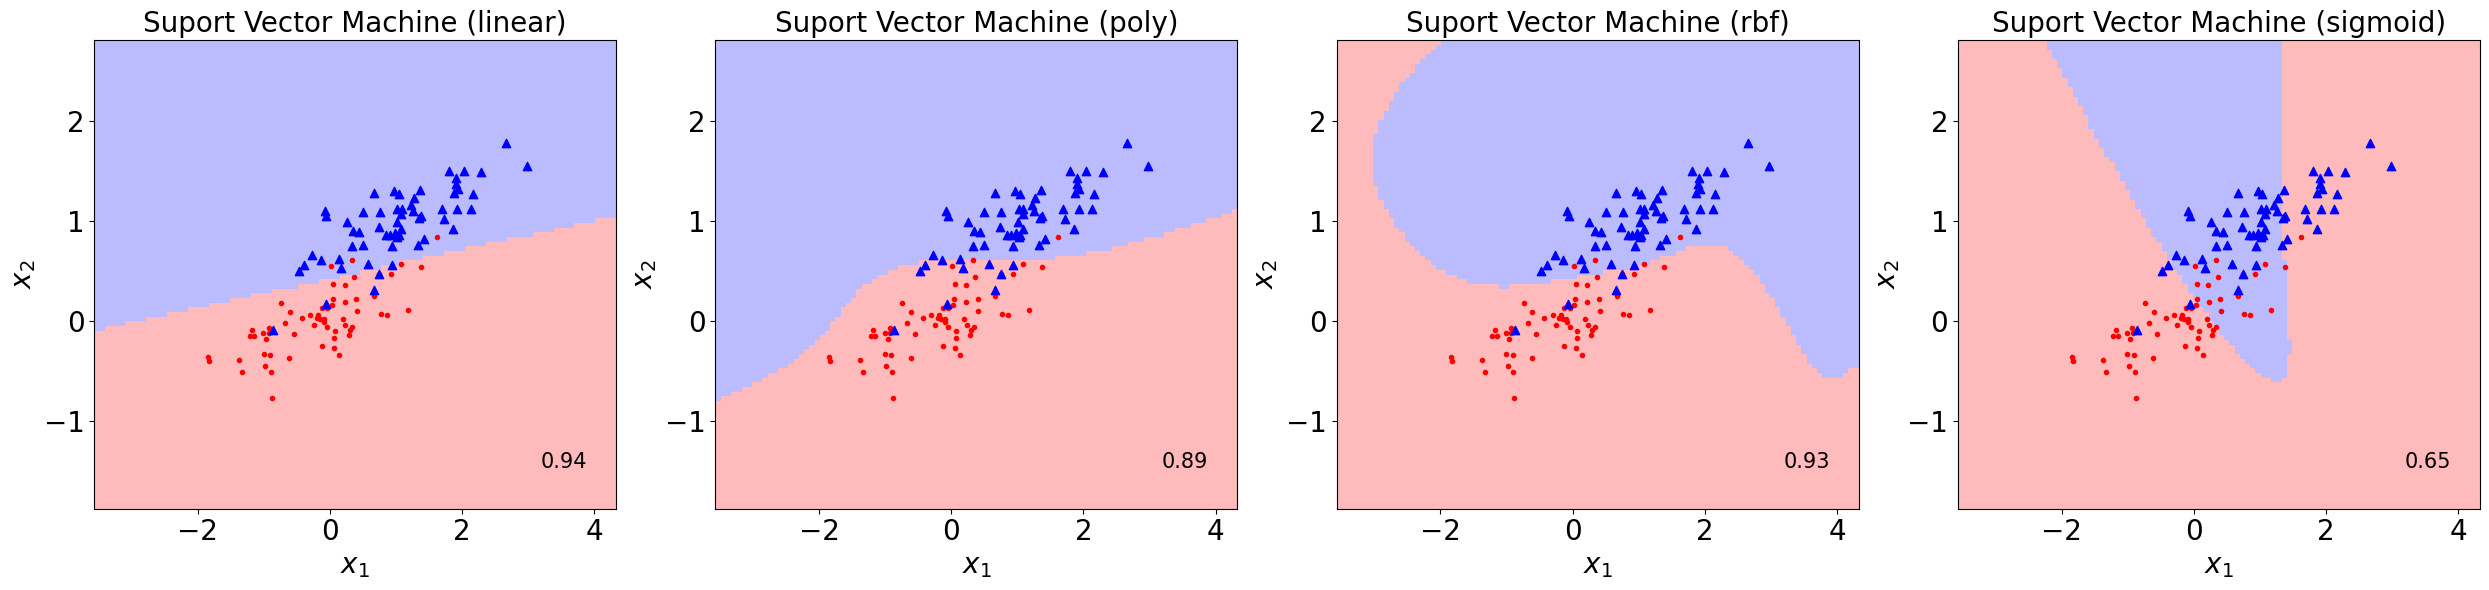

In [21]:
# Display
h = 0.05  # step size in the mesh
name = 'Suport Vector Machine'

nrows = 1
ncols = 4
Figure, axs = plt.subplots(nrows = nrows, ncols = ncols, figsize = (25,6))
for k, i in zip(kernels,range(len(kernels))):
    plt.sca(axs[i])
    axs[i].set_xlabel(r'$x_1$',fontsize = 20)
    axs[i].set_ylabel(r'$x_2$',fontsize = 20)
    axs[i].tick_params(labelsize=20)

    DecisionBoundaryDisplay.from_estimator(
        svms[kernels.index(k)],
        X,
        cmap=cmap_light_b,
        alpha=0.8,
        ax=axs[i],
        response_method="predict",
        plot_method="pcolormesh",
        shading="auto",
    )

# Plot also  testing points
#plt.scatter(X_test[:, 0], X_[:, 1], c=y, cmap=cmap_bold, edgecolor="k", s=20)
    axs[i].scatter(X0_t[:,0],X0_t[:,1], marker = '.', color='red')
    axs[i].scatter(X1_t[:,0],X1_t[:,1], marker = '^', color='blue')

    axs[i].set_title("{} ({})".format(name, k),fontsize=20)
    axs[i].text(
        0.9,
        0.1,
        "{:.2f}".format(accuracy_svms[kernels.index(k)]),
        size=15,
        ha="center",
        va="center",
        transform=plt.gca().transAxes,
    )

plt.tight_layout()

### $k$-Nearest Neighbors ($k$-NN)

In [22]:
from sklearn.neighbors import KNeighborsClassifier

#create the model classifier, the simplest one with 1 neighbor
#
n_neighbors = 1
knn = KNeighborsClassifier(n_neighbors=n_neighbors)

# train the model
knn.fit(X_train, y_train)

# Test the modelknn_clf=KNeighborsClassifier()
y_pred = knn.predict(X_test)
Test_model_accuracy (y_pred, y_test)



Accuracy (direct calculation):  0.8916666666666667
True positive:  52
True negative:  55
False positive:  6
False negative:  7
Accuracy (Conf. Matrix):  0.8916666666666667
Precision (Conf. Matrix):  0.896551724137931
Recall (Conf. Matrix):  0.8813559322033898
F1-score (Conf. Matrix):  0.888888888888889
F1-score (skl metrics):  0.888888888888889


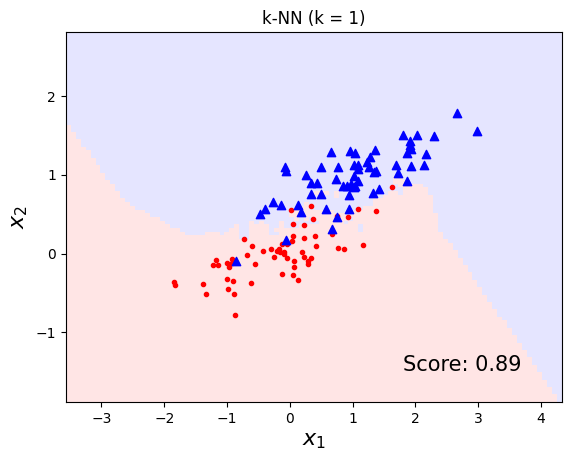

In [23]:
# Display
h = 0.05  # step size in the mesh
name = 'k-NN'
Figure, ax = plt.subplots()
ax.set_xlabel(r'$x_1$',fontsize = 16)
ax.set_ylabel(r'$x_2$',fontsize = 16)

DecisionBoundaryDisplay.from_estimator(
        knn,
        X,
        cmap=cmap_light_b,
        alpha=0.3,
        ax=ax,
        response_method="predict",
        plot_method="pcolormesh",
        shading="auto",
    )

# Plot also  test points according to their true class
ax.scatter(X0_t[:,0],X0_t[:,1], marker = '.', color='red')
ax.scatter(X1_t[:,0],X1_t[:,1], marker = '^', color='blue')

plt.title("{} (k = {})".format(name, n_neighbors))
plt.text(
        0.8,
        0.1,
        "Score: {:.2f}".format(f1_score(y_test, y_pred)),
        size=15,
        ha="center",
        va="center",
        transform=ax.transAxes,
)

Figure.show()


#### Analysis
* The decision line is close to the SVM model with the radial basis kernel (RBF) not too far from the dataset
* A closer look shows that probably with $k=1$ ($1$ neighbor) follows too closely the local environment of the training points: we find Class $1$ inside the region where we expect Class 0 points. **This is known as overfitting**
* $k=1$ does not contain enough information of the neighborhood of the points : this means that we have to find a better model

### Model Selection

Here we present a crude, yet comprehensive way of doing model selection.

The goal is to find the best value of $k$ that give the highest accuracy score

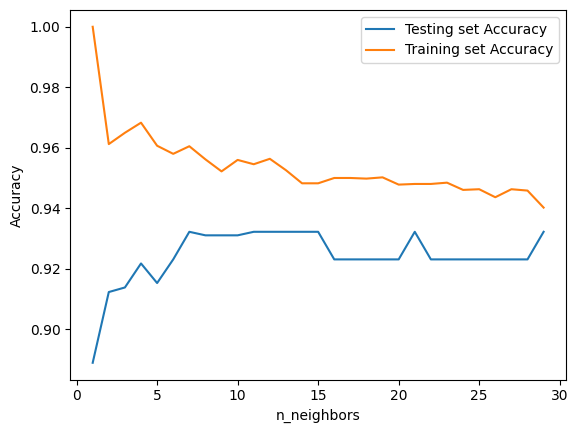

In [24]:
neighbors = np.arange(1, 30)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over K values
for i, k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    # Compute training and test data accuracy
#    train_accuracy[i] = knn.score(X_train, y_train)
    train_accuracy[i] = f1_score(y_train, knn.predict(X_train))
    test_accuracy[i] = f1_score(y_test, knn.predict(X_test))

# Generate plot
plt.plot(neighbors, test_accuracy, label = 'Testing set Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training set Accuracy')

plt.legend()
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.show()


In [25]:
# Select the model with the maximum accuracy and train it again
#
n_neighbors = np.argmax(test_accuracy)+1
knn = KNeighborsClassifier(n_neighbors=n_neighbors)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

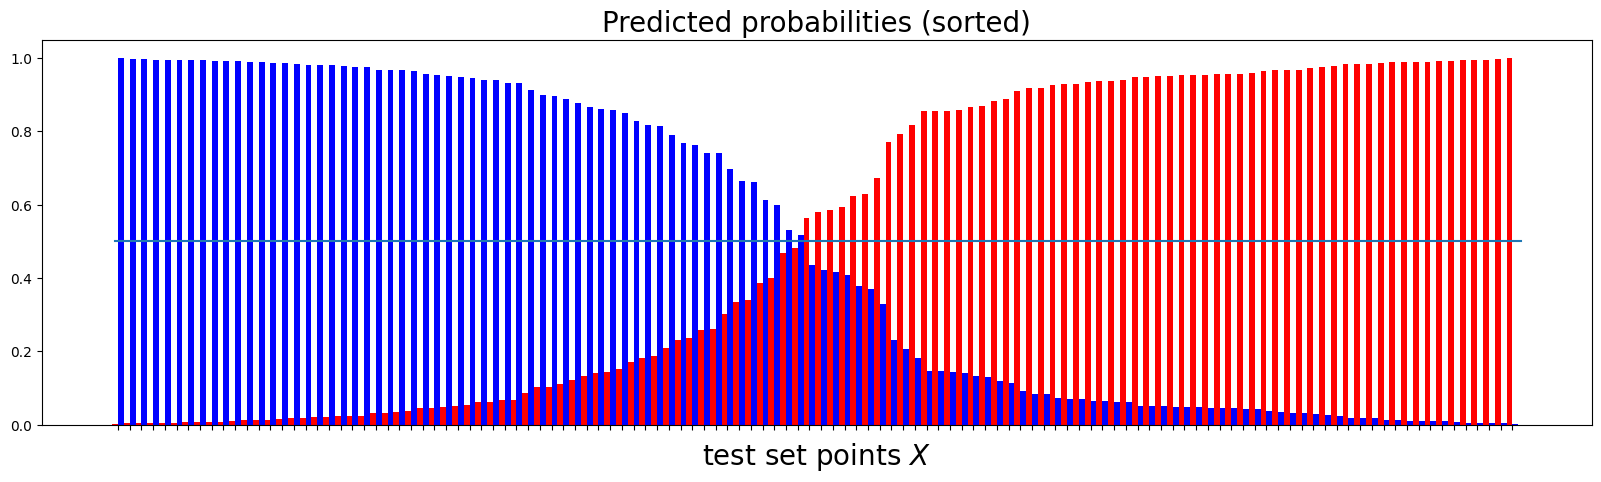

In [26]:
proba= knn.predict_proba(X_test)

barwidth = 0.5
figbar, ax1 = plt.subplots(nrows=1, ncols = 1,figsize = (20,5))
#ax1.tick_params(labelsize=18)
#ax2.tick_params(labelsize=18)

r1 = range(len(proba_log[:,0]))
r2 = [x + barwidth for x in r1]

prob_sort=[x.tolist() for x in sorted(proba_log, key=itemgetter(0))]
probA=[x[0] for x in prob_sort]
probB=[x[1] for x in prob_sort]

ax1.bar(r1, probA, width = barwidth, color=[color_class[0] for i in r1])
ax1.bar(r2, probB, width = barwidth, color=[color_class[1]for i in r1])
ax1.plot([0,len(proba_log[:,0])],[0.5,0.5])
ax1.set_title(r'Predicted probabilities (sorted)',fontsize = 20)
plt.xticks([r + barwidth / 2 for r in range(len(proba_log[:,0]))],[i for i in range(len(proba_log[:,0]),100)])
#ax2.set_title(r'Predicted probabilities of class $1$',fontsize = 20)
ax1.set_xlabel(r'test set points $X$',fontsize = 20)

figbar.show()

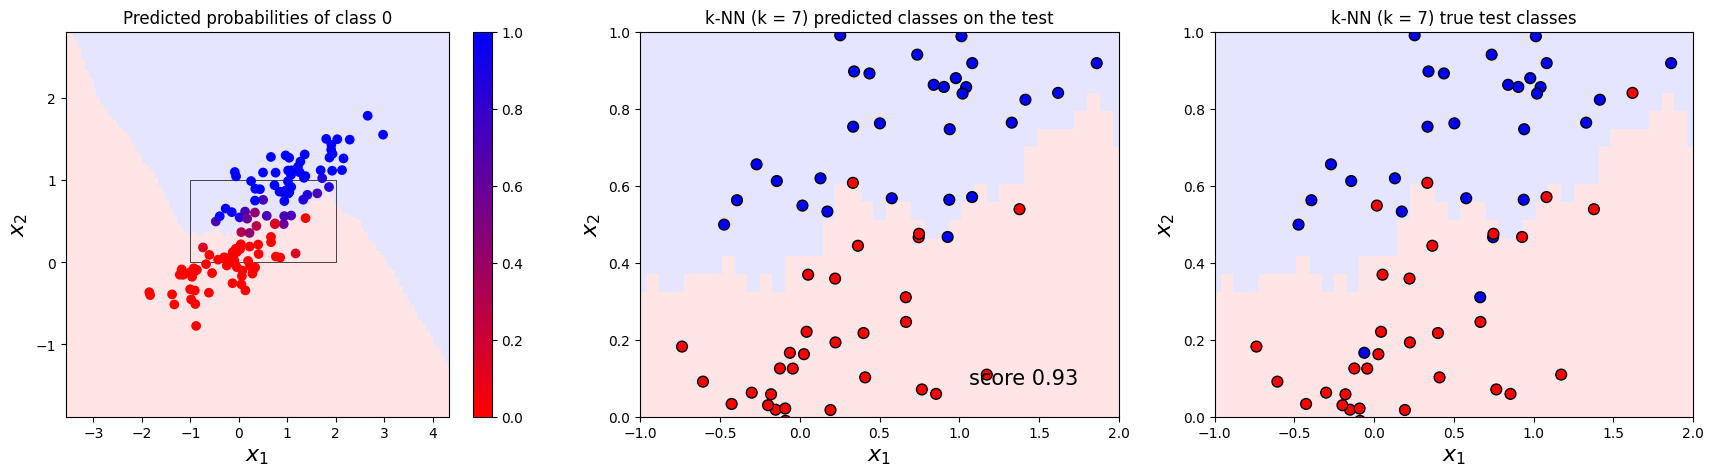

In [27]:
# Display
h = 0.05  # step size in the mesh
name = 'k-NN'
Figure, (ax,ax2,ax3) = plt.subplots(nrows = 1, ncols = 3, figsize = (21,5))
ax.set_xlabel(r'$x_1$',fontsize = 16)
ax.set_ylabel(r'$x_2$',fontsize = 16)

ax2.set_xlabel(r'$x_1$',fontsize = 16)
ax2.set_ylabel(r'$x_2$',fontsize = 16)
ax2.set_xlim(xmin=-1,xmax=2)
ax2.set_ylim(ymin=0,ymax=1)

ax3.set_xlabel(r'$x_1$',fontsize = 16)
ax3.set_ylabel(r'$x_2$',fontsize = 16)
ax3.set_xlim(xmin=-1,xmax=2)
ax3.set_ylim(ymin=0,ymax=1)

DecisionBoundaryDisplay.from_estimator(
        knn,
        X,
        cmap=cmap_light_b,
        alpha=0.3,
        ax=ax2,
        response_method="predict",
        plot_method="pcolormesh",
        shading="auto",
    )

ax2.set_title("{} (k = {}) predicted classes on the test".format(name, n_neighbors))
ax2.scatter(X_test[:, 0], X_test[:, 1], c=y_pred, cmap=cmap1, edgecolor="k", s=60)
ax2.text(
        0.8,
        0.1,
        "score {:.2f}".format(f1_score(y_test, y_pred)),
        size=15,
        ha="center",
        va="center",
        transform=ax2.transAxes,
)

DecisionBoundaryDisplay.from_estimator(
        knn,
        X,
        cmap=cmap_light_b,
        alpha=0.3,
        ax=ax3,
        response_method="predict",
        plot_method="pcolormesh",
        shading="auto",
    )
# Plot also testing points
#plt.scatter(X_test[:, 0], X_[:, 1], c=y, cmap=cmap_bold, edgecolor="k", s=20)

ax3.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap1, edgecolor="k", s=60)

ax3.set_title("{} (k = {}) true test classes".format(name, n_neighbors))

DecisionBoundaryDisplay.from_estimator(
        knn,
        X,
        cmap=cmap_light_b,
        alpha=0.3,
        ax=ax,
        response_method="predict",
        plot_method="pcolormesh",
        shading="auto",
    )

rect=Rectangle((-1, 0), 3, 1,
    facecolor = None,
    fill = None,
    edgecolor = "black",
    linewidth=0.5)

ax.add_patch(rect)

ax.set_title("Predicted probabilities of class 0")

# Plot also  testing points
#mycolors = cmap1(np.linspace(0,1,len(X_test)))
cm = ax.scatter(X_test[:,0],X_test[:,1], c = proba[:,1],cmap = cmap1)
Figure.colorbar(cm, ax=ax)

Figure.show()

## Multi-class classification

### Data Generation

In [28]:
# test classification dataset
from collections import Counter
from sklearn.datasets import make_classification

# define the random state
random_state = 1

# define the number of classes
n_classes = 3

# define dataset
Xm, ym = make_classification(n_samples=1000
                           , n_features=2
                           , n_informative=2
                           , n_redundant=0
                           , n_classes= n_classes
                           , n_clusters_per_class = 1
                           , class_sep = 1.7
                           , random_state=random_state)
# summarize the dataset
print(Xm.shape, ym.shape)
print(Counter(ym))

(1000, 2) (1000,)
Counter({1: 334, 0: 333, 2: 333})


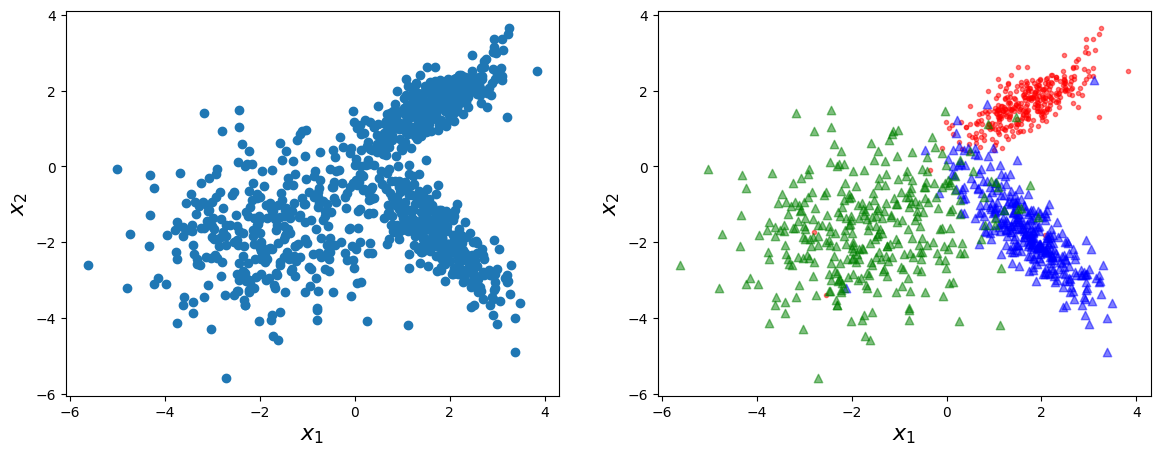

In [29]:
Figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
ax1.scatter(Xm[:,0],Xm[:,1])
ax1.set_xlabel(r'$x_1$',fontsize = 16)
ax1.set_ylabel(r'$x_2$',fontsize = 16)

X0m_s, X1m_s, X2m_s, = Xm[ym == 0], Xm[ym == 1], Xm[ym == 2]
ax2.scatter(X0m_s[:,0],X0m_s[:,1], marker = '.', color = color_class[0], alpha=0.5)
ax2.scatter(X1m_s[:,0],X1m_s[:,1], marker = '^', color = color_class[1], alpha=0.5)
ax2.scatter(X2m_s[:,0],X2m_s[:,1], marker = '^', color = color_class[2], alpha=0.5)
ax2.set_xlabel(r'$x_1$',fontsize = 16)
ax2.set_ylabel(r'$x_2$',fontsize = 16)
plt.show()

### Logistic regression

In [30]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import DecisionBoundaryDisplay

In [31]:
# define the multinomial logistic regression model
mlogreg = LogisticRegression(multi_class='multinomial', solver='lbfgs')

# define the model evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# evaluate the model and collect the scores
n_scores = cross_val_score(mlogreg, Xm, ym, scoring='accuracy', cv=cv, n_jobs=-1)

# report the model performance
print('Mean Accuracy: %.3f (+/- %.3f)' % (mean(n_scores), std(n_scores)))

Mean Accuracy: 0.947 (+/- 0.019)


In [32]:
# split the dataset into a train set and a test set : usually 80% of the data in the training
Xm_train, Xm_test, ym_train, ym_test = train_test_split(Xm, ym, test_size=0.20, random_state=random_state)

In [33]:
mlogreg.fit(Xm_train, ym_train)
ym_pred = mlogreg.predict(Xm_test)
proba_log = mlogreg.predict_proba(Xm_test)
# separate instances with classes 0 and 1 for the drawing
X0m_tr, X1m_tr, X2m_tr = Xm_train[ym_train == 0], Xm_train[ym_train == 1], Xm_train[ym_train == 2]
X0m_t, X1m_t, X2m_t = Xm_test[ym_test == 0], Xm_test[ym_test == 1], Xm_test[ym_test == 2]


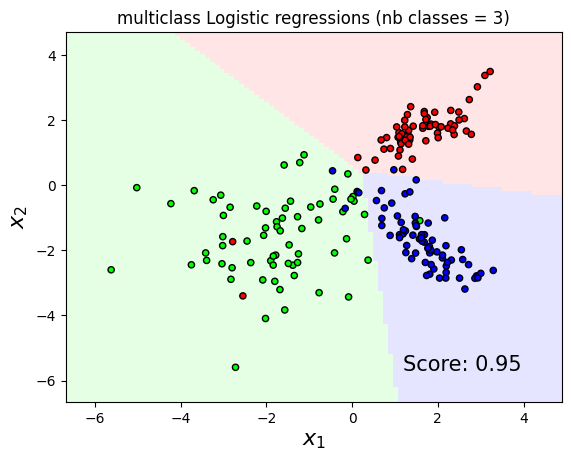

In [34]:
h = 0.05  # step size in the mesh
name = 'multiclass Logistic regressions'
Figure, ax = plt.subplots()
ax.set_xlabel(r'$x_1$',fontsize = 16)
ax.set_ylabel(r'$x_2$',fontsize = 16)

DecisionBoundaryDisplay.from_estimator(
        mlogreg,
        Xm,
        cmap=cmap_light,
        alpha=0.3,
        ax=ax,
        response_method="predict",
        plot_method="pcolormesh",
        shading="auto",
    )

# Plot also  test points according to their true class
plt.scatter(Xm_test[:, 0], Xm_test[:, 1], c=ym_test, cmap=cmap_bold, edgecolor="k", s=20)

plt.title("{} (nb classes = {})".format(name, n_classes))
plt.text(
        0.8,
        0.1,
        "Score: {:.2f}".format(mean(n_scores)),
        size=15,
        ha="center",
        va="center",
        transform=ax.transAxes,
)

Figure.show()

In [35]:
# Choose a point and predict its class
point = [[-4, -4]]
point_class = mlogreg.predict(point)

<ipython-input-36-e80a929c0744>:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.scatter(point[0][0],point[0][1], marker = '*', s=400, c = color_class[int(point_class)], edgecolor="yellow")


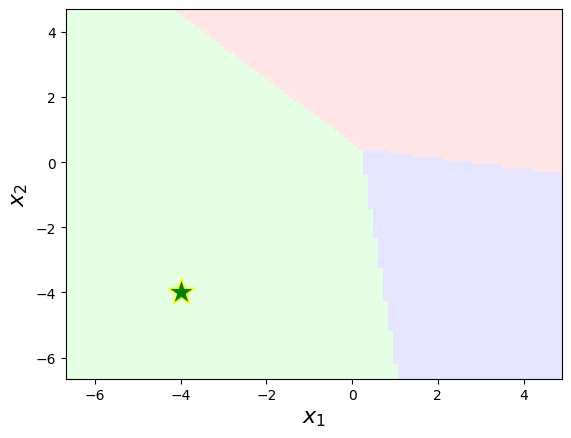

In [36]:
Figure, ax = plt.subplots()
ax.set_xlabel(r'$x_1$',fontsize = 16)
ax.set_ylabel(r'$x_2$',fontsize = 16)

DecisionBoundaryDisplay.from_estimator(
        mlogreg,
        Xm,
        cmap=cmap_light,
        alpha=0.3,
        ax=ax,
        response_method="predict",
        plot_method="pcolormesh",
        shading="auto",
    )

ax.scatter(point[0][0],point[0][1], marker = '*', s=400, c = color_class[int(point_class)], edgecolor="yellow")

Figure.show()

### Support Vector Machines

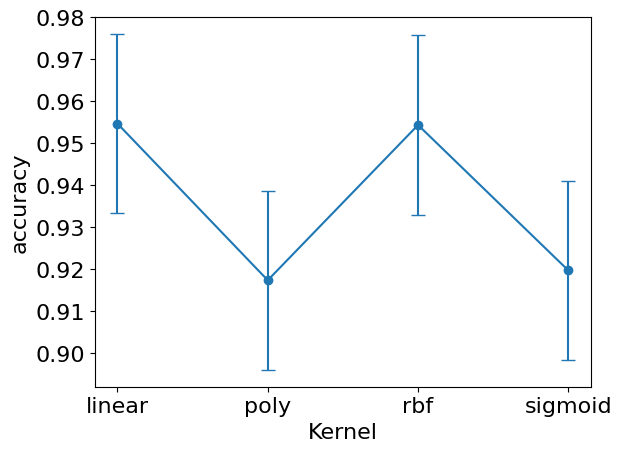

In [37]:
kernels = ['linear', 'poly','rbf','sigmoid']

svms=[]
predict_svms=[]
accuracy_svms = []

# Create and train for each SVM model
#
for k in kernels:
    svm = SVC(kernel=k) # 'lbf' kernel is used here.
    svm.fit(Xm_train, ym_train)
    svms.append(svm)
    # Make predictions and evaluate the model
    ym_pred = svm.predict(Xm_test)
    predict_svms.append(ym_pred)
    n_scores = cross_val_score(svm, Xm, ym, scoring='accuracy', cv=cv, n_jobs=-1)
    accuracy_svms.append(mean(n_scores))

plt.scatter(kernels,accuracy_svms)
plt.errorbar(kernels, accuracy_svms, yerr=std(n_scores), capsize=5)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlabel(r'Kernel',fontsize = 16)
plt.ylabel(r'accuracy',fontsize = 16)
plt.show()

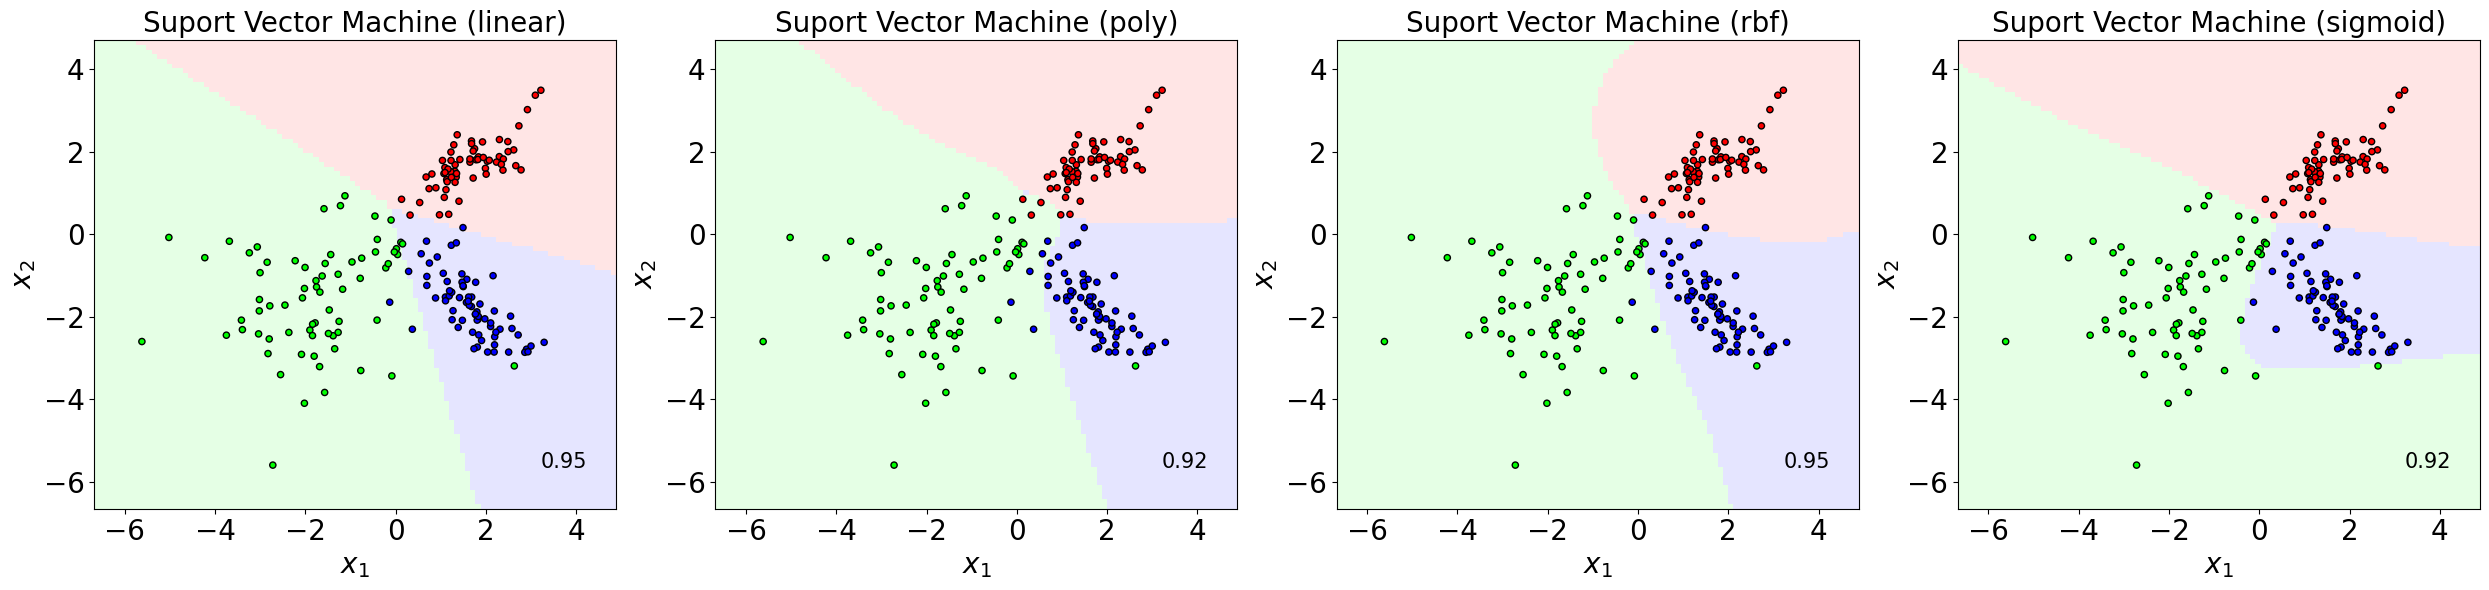

In [38]:
# Display
h = 0.05  # step size in the mesh
name = 'Suport Vector Machine'

nrows = 1
ncols = 4
Figure, axs = plt.subplots(nrows = nrows, ncols = ncols, figsize = (25,6))
for k, i in zip(kernels,range(len(kernels))):
    plt.sca(axs[i])
    axs[i].set_xlabel(r'$x_1$',fontsize = 20)
    axs[i].set_ylabel(r'$x_2$',fontsize = 20)
    axs[i].tick_params(labelsize=20)

    DecisionBoundaryDisplay.from_estimator(
        svms[kernels.index(k)],
        Xm,
        cmap=cmap_light,
        alpha=0.3,
        ax=axs[i],
        response_method="predict",
        plot_method="pcolormesh",
        shading="auto",
    )

# Plot also  testing points
    axs[i].scatter(Xm_test[:, 0], Xm_test[:, 1], c=ym_pred, cmap=cmap_bold, edgecolor="k", s=20)
    axs[i].set_title("{} ({})".format(name, k),fontsize=20)
    axs[i].text(
        0.9,
        0.1,
        "{:.2f}".format(accuracy_svms[kernels.index(k)]),
        size=15,
        ha="center",
        va="center",
        transform=plt.gca().transAxes,
    )

plt.tight_layout()

### K-NN with $k=1$

In [39]:
from sklearn.neighbors import KNeighborsClassifier

#create the model classifier, the simplest one with 1 neighbor
#
n_neighbors = 1
knn1 = KNeighborsClassifier(n_neighbors=n_neighbors)

# train the model
knn1.fit(Xm_train, ym_train)

# Test the modelknn_clf=KNeighborsClassifier()
ym_pred = knn1.predict(Xm_test)

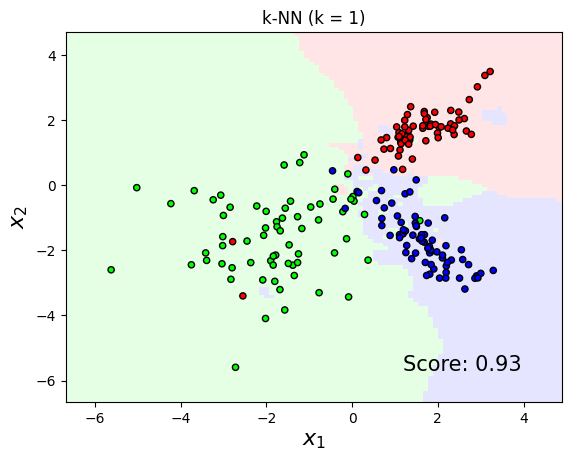

In [40]:
# Display
h = 0.05  # step size in the mesh
name = 'k-NN'
Figure, ax = plt.subplots()
ax.set_xlabel(r'$x_1$',fontsize = 16)
ax.set_ylabel(r'$x_2$',fontsize = 16)

DecisionBoundaryDisplay.from_estimator(
        knn1,
        Xm,
        cmap=cmap_light,
        alpha=0.3,
        ax=ax,
        response_method="predict",
        plot_method="pcolormesh",
        shading="auto",
    )

plt.scatter(Xm_test[:, 0], Xm_test[:, 1], c=ym_test, cmap=cmap_bold, edgecolor="k", s=20)
plt.title("{} (k = {})".format(name, n_neighbors))
plt.text(
        0.8,
        0.1,
        "Score: {:.2f}".format(f1_score(y_test, y_pred)),
        size=15,
        ha="center",
        va="center",
        transform=ax.transAxes,
)
Figure.show()


## Exercise: make a svm classification with a dataset of 4 classes  

Here is the dataset that you are going to work on.


In [41]:
# test classification dataset
from collections import Counter
from sklearn.datasets import make_classification

# define the random state
random_state = 1

# define the number of classes
n_classes = 4

# define dataset
Xc, yc = make_classification(n_samples=3000
                           , n_features=2
                           , n_informative= 2
                           , n_redundant=0
                           , n_classes= n_classes
                           , n_clusters_per_class = 1
                           , class_sep = 1.7
                           , random_state=random_state)
# summarize the dataset
print(Xc.shape, yc.shape)
print(Counter(yc))
print(yc)

(3000, 2) (3000,)
Counter({1: 753, 2: 751, 3: 749, 0: 747})
[2 2 3 ... 0 3 0]


Tasks:
1. Visualise the data, perform a train/test split
2. Train and evaluate the 4 different SMV models
3. Draw the predictions (décision lines)
4. Which SVM model seems to be the most suitable for a classification ?

## Soluction

### Visualise the data

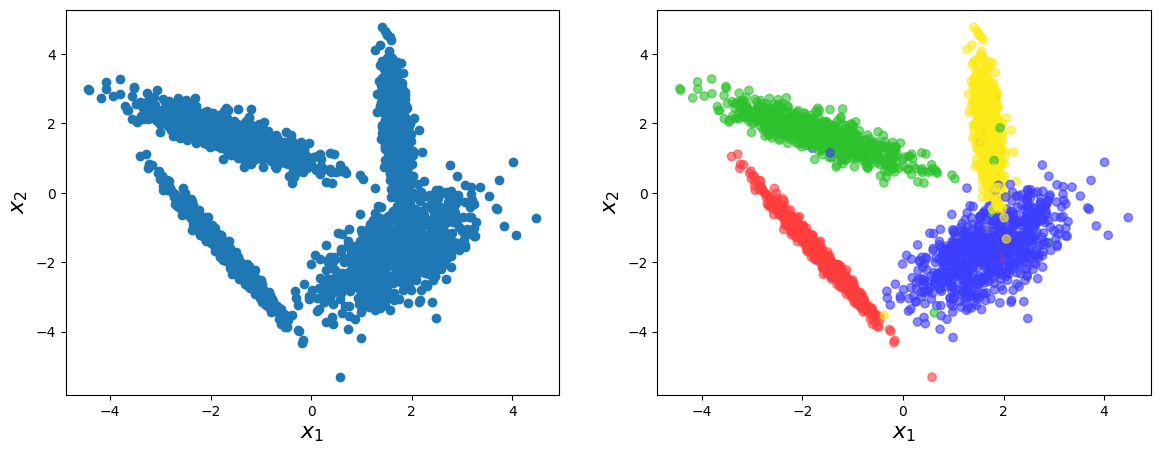

In [42]:
Figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
ax1.scatter(Xc[:,0],Xc[:,1])
ax1.set_xlabel(r'$x_1$',fontsize = 16)
ax1.set_ylabel(r'$x_2$',fontsize = 16)


ax2.scatter(Xc[:,0],Xc[:,1], c = yc, cmap = my_cmap, alpha = 0.6)
ax2.set_xlabel(r'$x_1$',fontsize = 16)
ax2.set_ylabel(r'$x_2$',fontsize = 16)
plt.show()

### Train-test split

In [43]:
# split the dataset into a train set and a test set : usually 80% of the data in the training
Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc, yc, test_size=0.20, random_state=random_state)

### Train the models

In [44]:
svms=[]
predict_svms=[]
accuracy_svms = []

# Create and train for each SVM model
#
for k in kernels:
    svm = SVC(kernel=k) # 'lbf' kernel is used here.
    svm.fit(Xc_train, yc_train)
    svms.append(svm)
    # Make predictions and evaluate the model
    yc_pred = svm.predict(Xc_test)
    predict_svms.append(yc_pred)
    n_scores = cross_val_score(svm, Xc, yc, scoring='accuracy', cv=cv, n_jobs=-1)
    accuracy_svms.append(mean(n_scores))

### Visualize the predictions

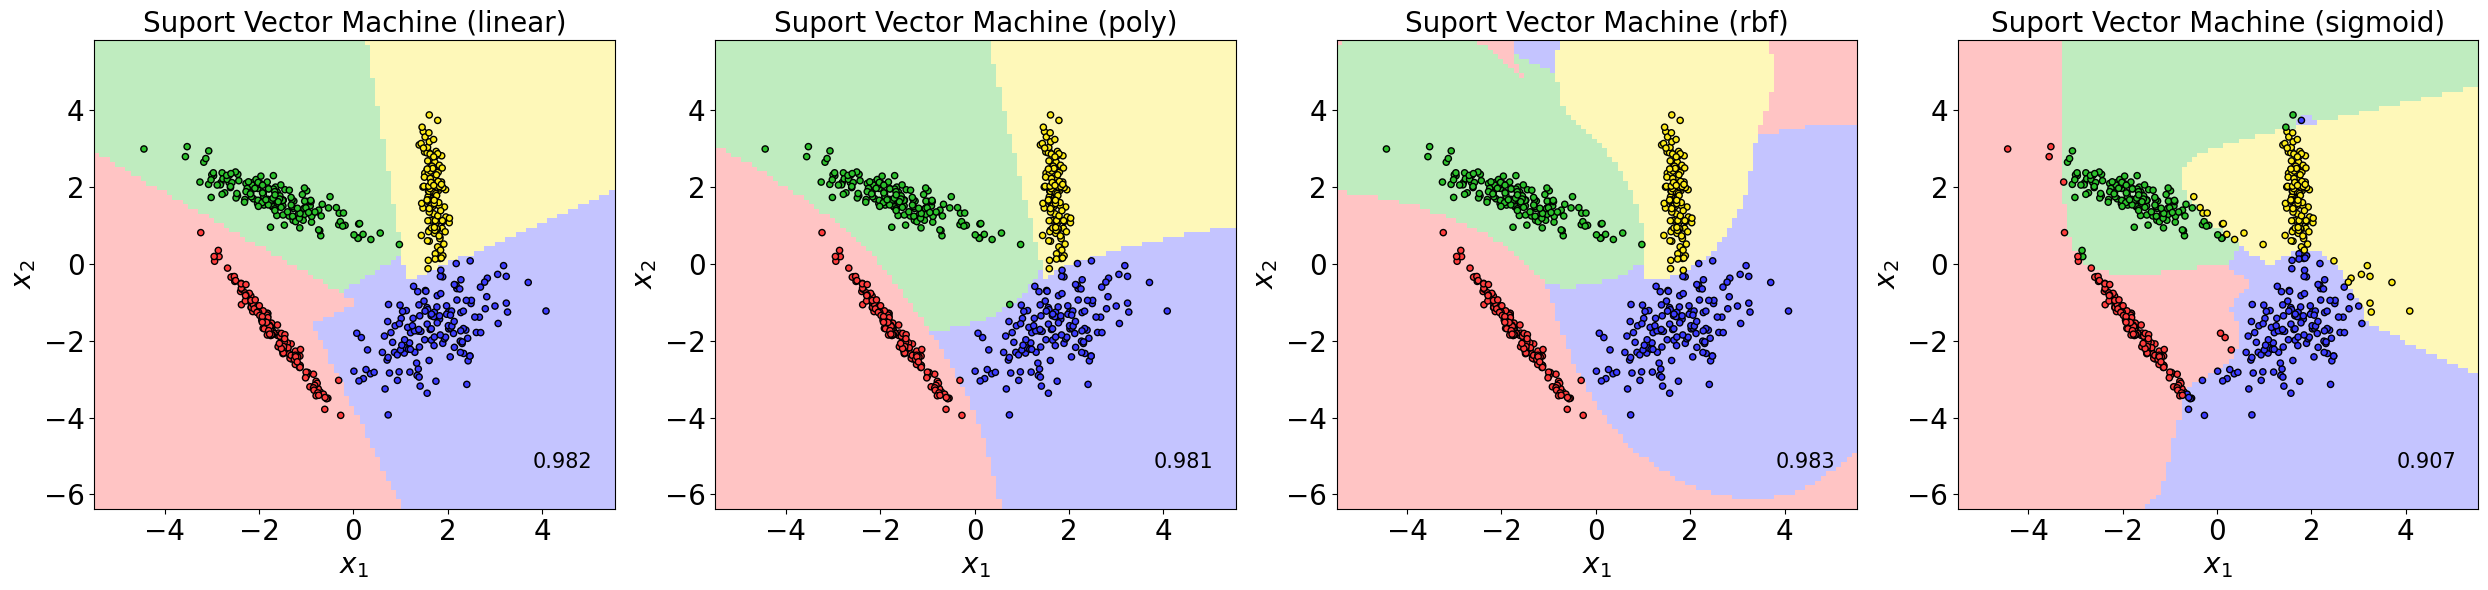

In [45]:
# Display
h = 0.05  # step size in the mesh
name = 'Suport Vector Machine'

nrows = 1
ncols = 4
Figure, axs = plt.subplots(nrows = nrows, ncols = ncols, figsize = (25,6))
for k, i in zip(kernels,range(len(kernels))):
    plt.sca(axs[i])
    axs[i].set_xlabel(r'$x_1$',fontsize = 20)
    axs[i].set_ylabel(r'$x_2$',fontsize = 20)
    axs[i].tick_params(labelsize=20)

    DecisionBoundaryDisplay.from_estimator(
        svms[kernels.index(k)],
        Xc,
        cmap=my_cmap,
        alpha=0.3,
        ax=axs[i],
        response_method="predict",
        plot_method="pcolormesh",
        shading="auto",
    )

    # Plot also  testing points
    axs[i].scatter(Xc_test[:, 0], Xc_test[:, 1], c=predict_svms[i], cmap=my_cmap, edgecolor="k", s=20)


    axs[i].set_title("{} ({})".format(name, k),fontsize=20)
    axs[i].text(
        0.9,
        0.1,
        "{:.3f}".format(accuracy_svms[kernels.index(k)]),
        size=15,
        ha="center",
        va="center",
        transform=plt.gca().transAxes,
    )

plt.tight_layout()

-----------------------------

## Example from Materials Science: Real Data [WIP]